# Исследование технологического процесса очистки золота.


## Описание проекта


Строится модель машинного обучения для промышленной компании, разрабатывающая решения для эффективной работы промышленных предприятий. Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды на основе данных с параметрами добычи и очистки. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

**Цель исследования:** 

Спрогнозировать концентрацию золота при проведении процесса очистки золота.


## Подготовка данных

### Импортируем библиотеки, которые будем использовать в дальнейшем.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

### Загружаем данные

In [2]:
df_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
df_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
df_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

### Задаем функции для повторяющихся действий.

In [3]:
def df_info(df: pd.DataFrame):
    display(df.info())
    display(df.describe().T)
    display(df.sample(10))
    print(f"Количество дубликатов: {df.duplicated().sum()}")

def custom_hist(x: pd.Series, x_label: str, title: str):
    plt.figure(figsize=(10,7))
    plt.hist(x, edgecolor="black", bins = 10)
    plt.grid()
    pl.xlabel(x_label)
    pl.ylabel("Количество")
    pl.title(title)
    plt.show()

### Приводим названия столбцов к общепринятому виду.

In [4]:
df_train = df_train.rename(
    columns=lambda col: col.replace(".", "_"))
df_test = df_test.rename(
    columns=lambda col: col.replace(".", "_"))
df_full = df_full.rename(
    columns=lambda col: col.replace(".", "_"))


### Создаем функцию для расчета эффективности, где:



- C — доля золота в концентрате после флотации
- F — доля золота в сырье до флотации
- T — доля золота в отвальных хвостах после флотации

In [5]:
def recovery (c, f, t):
    result = (c*(f-t))/(f*(c-t))
    return result*100

### Вычисляем recovery и MAE

In [6]:
df_train['recovery_new'] = recovery(df_train['rougher_output_concentrate_au'],
                                              df_train['rougher_input_feed_au'],
                                              df_train['rougher_output_tail_au'])

print('MAE =', mean_absolute_error(df_train['rougher_output_recovery'], df_train['recovery_new']))

MAE = 9.73512347450521e-15


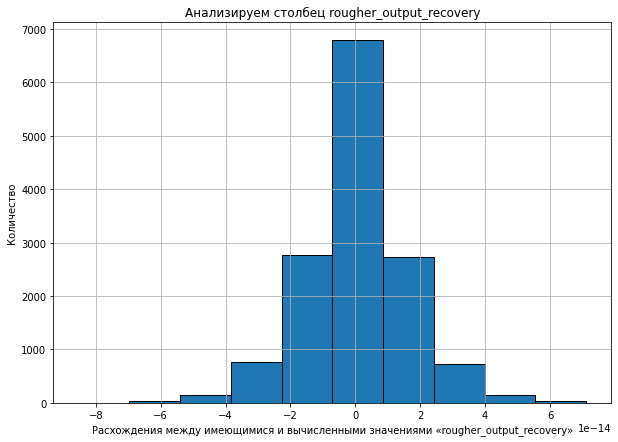

In [7]:
custom_hist(
    (df_train['recovery_new'] - df_train['rougher_output_recovery']),
    'Расхождения между имеющимися и вычисленными значениями «rougher_output_recovery»',
    'Анализируем столбец rougher_output_recovery')

Принимаем решение использовать вычисленный признак «rougher_output_recovery» чтобы минимизировать погрешность.

### Смотрим каких столбцов нет в тестовой выборке

In [8]:
set(df_full.columns) - set(df_test.columns)

{'final_output_concentrate_ag',
 'final_output_concentrate_au',
 'final_output_concentrate_pb',
 'final_output_concentrate_sol',
 'final_output_recovery',
 'final_output_tail_ag',
 'final_output_tail_au',
 'final_output_tail_pb',
 'final_output_tail_sol',
 'primary_cleaner_output_concentrate_ag',
 'primary_cleaner_output_concentrate_au',
 'primary_cleaner_output_concentrate_pb',
 'primary_cleaner_output_concentrate_sol',
 'primary_cleaner_output_tail_ag',
 'primary_cleaner_output_tail_au',
 'primary_cleaner_output_tail_pb',
 'primary_cleaner_output_tail_sol',
 'rougher_calculation_au_pb_ratio',
 'rougher_calculation_floatbank10_sulfate_to_au_feed',
 'rougher_calculation_floatbank11_sulfate_to_au_feed',
 'rougher_calculation_sulfate_to_au_concentrate',
 'rougher_output_concentrate_ag',
 'rougher_output_concentrate_au',
 'rougher_output_concentrate_pb',
 'rougher_output_concentrate_sol',
 'rougher_output_recovery',
 'rougher_output_tail_ag',
 'rougher_output_tail_au',
 'rougher_output_ta

#### Вывод.

Нет выходных и расчетных параметров. 

### Дополним тестовую выборку целевыми признаками.

In [9]:
df_full['recovery_new'] = recovery(df_full['rougher_output_concentrate_au'],
                                              df_full['rougher_input_feed_au'],
                                              df_full['rougher_output_tail_au'])

df_test[['recovery_new', 'final_output_recovery']] = df_full[
    ['recovery_new', 'final_output_recovery']].loc[df_test.index]

### Убираем из обучающей выборки данные которых нет в тестовой.

In [10]:
df_train = df_train.drop((set(df_train) - set(df_test.columns)), axis=1)

### Смотрим что получилось.

In [11]:
df_info(df_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        14149 non-null  object 
 1   final_output_recovery                       14149 non-null  float64
 2   primary_cleaner_input_sulfate               14129 non-null  float64
 3   primary_cleaner_input_depressant            14117 non-null  float64
 4   primary_cleaner_input_feed_size             14149 non-null  float64
 5   primary_cleaner_input_xanthate              14049 non-null  float64
 6   primary_cleaner_state_floatbank8_a_air      14145 non-null  float64
 7   primary_cleaner_state_floatbank8_a_level    14148 non-null  float64
 8   primary_cleaner_state_floatbank8_b_air      14145 non-null  float64
 9   primary_cleaner_state_floatbank8_b_level    14148 non-null  float64
 10  primary_cl

None

,count,mean,std,min,25%,50%,75%,max
final_output_recovery,14149.0,66.518832,10.295402,0.000000,62.545817,67.432775,72.346428,100.000000
primary_cleaner_input_sulfate,14129.0,133.320659,39.431659,0.003112,107.006651,133.018328,159.825396,250.127834
primary_cleaner_input_depressant,14117.0,8.866996,3.361589,0.000000,6.040604,8.035811,11.522173,20.052255
primary_cleaner_input_feed_size,14149.0,7.322310,0.614062,1.080000,6.960000,7.290000,7.700000,10.470000
primary_cleaner_input_xanthate,14049.0,0.885588,0.372714,0.000005,0.607021,0.888749,1.100933,2.512968
primary_cleaner_state_floatbank8_a_air,14145.0,1608.000064,128.394355,0.006352,1595.695815,1601.824410,1699.716408,2079.531340
primary_cleaner_state_floatbank8_a_level,14148.0,-488.775525,35.704184,-798.641662,-500.287952,-499.909375,-499.378551,-330.134203
primary_cleaner_state_floatbank8_b_air,14145.0,1608.610983,131.112729,0.008700,1558.959943,1601.818514,1700.215351,2114.906758
primary_cleaner_state_floatbank8_b_level,14148.0,-489.171786,33.604449,-740.122129,-500.375645,-499.938003,-499.389658,-347.354380
primary_cleaner_state_floatbank8_c_air,14147.0,1608.879407,134.266898,0.015159,1549.871886,1601.574628,1700.464037,2013.156457


,date,final_output_recovery,primary_cleaner_input_sulfate,primary_cleaner_input_depressant,primary_cleaner_input_feed_size,primary_cleaner_input_xanthate,primary_cleaner_state_floatbank8_a_air,primary_cleaner_state_floatbank8_a_level,primary_cleaner_state_floatbank8_b_air,primary_cleaner_state_floatbank8_b_level,...,secondary_cleaner_state_floatbank4_a_level,secondary_cleaner_state_floatbank4_b_air,secondary_cleaner_state_floatbank4_b_level,secondary_cleaner_state_floatbank5_a_air,secondary_cleaner_state_floatbank5_a_level,secondary_cleaner_state_floatbank5_b_air,secondary_cleaner_state_floatbank5_b_level,secondary_cleaner_state_floatbank6_a_air,secondary_cleaner_state_floatbank6_a_level,recovery_new
7707,2017-06-02 03:59:59,57.896660,115.129206,13.296829,6.660000,0.989606,1501.839181,-499.354948,1500.006831,-499.223490,...,-501.802723,22.986703,-380.388348,20.086566,-500.379100,20.082106,-500.093883,14.992580,-502.326021,79.634424
13114,2018-06-23 02:59:59,63.518701,164.309088,4.001220,7.360000,1.889420,1801.197492,-501.532006,1799.308278,-497.856930,...,-508.239615,22.916517,-460.489092,20.002705,-503.726568,15.980652,-500.233939,15.989075,-501.521502,92.284274
1738,2016-04-12 04:00:00,66.813867,84.980333,12.052316,6.880000,0.903001,1800.678021,-501.545693,1801.508020,-500.148499,...,-495.077804,12.021601,-481.665319,18.983148,-500.104626,18.936860,-500.057740,30.034110,-501.640671,79.503570
5461,2017-02-09 07:59:59,69.409672,139.125203,5.539374,6.640000,0.746212,1798.235656,-399.925424,1799.046865,-399.636855,...,-401.939850,22.998921,-400.988274,22.980003,-450.455499,19.998136,-449.778252,24.998932,-600.197467,87.369112
11088,2018-03-19 04:59:59,69.700395,99.524038,6.033375,6.410000,1.391478,1697.596748,-500.656502,1698.425433,-499.721207,...,-500.239339,15.107120,-500.324632,18.017864,-500.017934,11.999781,-500.273527,12.006548,-500.428593,91.492254
1298,2016-03-15 19:00:00,60.283545,114.631089,12.015547,7.946667,0.700680,1599.138132,-398.643222,1600.707619,-400.915796,...,-499.531376,11.900889,-500.135734,12.010415,-500.599127,9.987535,-500.054159,20.033350,-500.653751,77.495756
11109,2018-03-20 08:59:59,66.769927,131.144259,8.989394,6.410000,1.386138,1665.199674,-498.724647,1700.438227,-498.583942,...,-500.649431,14.933124,-500.203210,30.003613,-500.282485,15.008345,-500.079843,13.000873,-500.069609,87.415229
13160,2018-06-25 00:59:59,73.350834,167.814205,7.999007,7.420000,0.604407,1699.832212,-499.710536,1697.219887,-500.555267,...,-500.505555,22.980588,-500.760432,19.944714,-499.579841,14.986236,-500.064950,16.000621,-499.545400,92.841646
1732,2016-04-11 22:00:00,60.890062,77.093475,11.932652,7.500000,0.988157,1799.240525,-500.323189,1799.832691,-500.927026,...,-501.203267,11.984346,-487.685273,18.988944,-499.277279,18.998123,-500.564757,30.027752,-501.375687,79.217892
11766,2018-04-22 10:59:59,72.139039,140.687508,7.982810,8.230000,1.310504,1700.558012,-497.121949,1700.736844,-502.725800,...,-500.107198,20.015956,-499.880800,19.977434,-497.967648,15.002446,-499.226262,17.990864,-499.350372,94.358889


Количество дубликатов: 0


In [12]:
df_info(df_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner_input_sulfate               5286 non-null   float64
 2   primary_cleaner_input_depressant            5285 non-null   float64
 3   primary_cleaner_input_feed_size             5290 non-null   float64
 4   primary_cleaner_input_xanthate              5286 non-null   float64
 5   primary_cleaner_state_floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner_state_floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner_state_floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner_state_floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner_state_floatbank8_c_air      5290 non-null   float64
 10  primary_clea

None

,count,mean,std,min,25%,50%,75%,max
primary_cleaner_input_sulfate,5286.0,174.839652,43.027080,2.566156e+00,147.121401,177.828489,208.125438,265.983123
primary_cleaner_input_depressant,5285.0,8.683596,3.072050,3.839482e-03,6.489555,8.052207,10.027764,40.000000
primary_cleaner_input_feed_size,5290.0,7.266339,0.610219,5.650000e+00,6.890000,7.250000,7.600000,15.500000
primary_cleaner_input_xanthate,5286.0,1.383803,0.643474,4.983673e-03,0.907623,1.197610,1.797819,4.102454
primary_cleaner_state_floatbank8_a_air,5290.0,1539.494325,116.797884,5.445860e-32,1498.935802,1585.129123,1602.076529,2103.103580
primary_cleaner_state_floatbank8_a_level,5290.0,-497.665883,19.952431,-7.953163e+02,-500.357298,-499.969164,-499.568951,-57.195404
primary_cleaner_state_floatbank8_b_air,5290.0,1545.174232,122.224588,6.647490e-32,1498.970993,1595.621798,1602.323545,1813.083671
primary_cleaner_state_floatbank8_b_level,5290.0,-500.273098,32.968307,-7.999970e+02,-500.703002,-500.028514,-499.293257,-142.527229
primary_cleaner_state_floatbank8_c_air,5290.0,1527.272362,122.538034,4.033736e-32,1473.229862,1549.594682,1601.143775,1715.053773
primary_cleaner_state_floatbank8_c_level,5290.0,-498.330680,21.964876,-7.999606e+02,-501.018117,-500.017711,-498.994130,-150.937035


,date,primary_cleaner_input_sulfate,primary_cleaner_input_depressant,primary_cleaner_input_feed_size,primary_cleaner_input_xanthate,primary_cleaner_state_floatbank8_a_air,primary_cleaner_state_floatbank8_a_level,primary_cleaner_state_floatbank8_b_air,primary_cleaner_state_floatbank8_b_level,primary_cleaner_state_floatbank8_c_air,...,secondary_cleaner_state_floatbank4_b_air,secondary_cleaner_state_floatbank4_b_level,secondary_cleaner_state_floatbank5_a_air,secondary_cleaner_state_floatbank5_a_level,secondary_cleaner_state_floatbank5_b_air,secondary_cleaner_state_floatbank5_b_level,secondary_cleaner_state_floatbank6_a_air,secondary_cleaner_state_floatbank6_a_level,recovery_new,final_output_recovery
755,2016-10-12 12:59:59,207.369320,8.038816,8.14,0.715277,1501.734730,-500.535537,1496.709750,-500.113864,1500.357389,...,11.946159,-500.363220,9.432121,-499.965957,8.013406,-499.748750,16.912200,-500.953884,93.970408,73.829220
2445,2016-12-24 03:59:59,141.484318,11.502951,6.98,1.454377,1547.370858,-499.951815,1550.611780,-500.011545,1554.643496,...,15.004438,-499.517461,13.631698,-499.533772,12.050663,-499.374077,21.007546,-499.964429,88.635574,67.968977
2503,2016-12-27 03:59:59,201.760833,13.504123,7.45,1.101832,1666.513442,-500.070624,1683.090078,-500.214950,1681.721644,...,14.936387,-500.102521,12.648630,-499.850516,11.994132,-500.216112,20.989717,-499.834846,77.579527,68.581945
5164,2017-12-25 15:59:59,209.093593,14.977983,7.90,0.778355,1603.908992,-398.999165,1599.643633,-394.301622,1274.102266,...,15.033307,-500.683163,10.992322,-500.879779,9.032122,-500.048517,12.016577,-502.755409,85.453378,66.283864
2209,2016-12-14 02:59:59,170.032088,9.496288,7.70,1.499836,1596.907329,-499.846126,1557.791754,-499.067050,1602.446261,...,14.999941,-502.128669,18.561743,-500.184437,12.007037,-499.992647,20.980893,-499.840756,75.217812,50.802992
4480,2017-11-25 10:59:59,208.661530,8.480312,7.08,2.498088,1638.721902,-500.393323,1638.698451,-499.004403,1610.426862,...,14.921303,-497.450298,10.949830,-498.466498,9.035722,-499.727891,16.002827,-498.332984,88.747090,72.873538
1434,2016-11-10 11:59:59,109.744794,4.975846,7.02,0.892982,1602.508768,-499.894465,1602.676449,-499.802835,1599.105334,...,13.926332,-528.256813,13.124144,-321.047753,13.954169,-219.293044,21.977466,-209.198714,83.104540,68.807010
4609,2017-11-30 21:59:59,223.897773,9.000606,8.56,2.596607,1547.703456,-501.026923,1550.081765,-498.237241,1547.779243,...,15.035992,-270.899273,10.032621,-474.289732,8.020686,-444.778920,15.992564,-496.225985,82.959648,66.876404
1333,2016-11-06 03:59:59,146.315569,7.002108,7.22,0.902543,1603.771627,-499.338390,1601.934800,-500.299595,1602.170505,...,12.987817,-500.011371,17.757932,-499.452311,13.983635,-499.916123,23.975486,-498.904137,80.379402,64.023029
3239,2017-10-01 09:59:59,151.506440,6.568344,6.52,1.990833,1592.084588,-498.388438,1601.929367,-501.131478,1599.514086,...,15.024838,-400.119252,13.042754,-499.894834,10.933839,-499.905063,15.025518,-499.989124,70.729473,62.076133


Количество дубликатов: 0


In [13]:
df_info(df_full)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 88 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final_output_concentrate_ag                         19438 non-null  float64
 2   final_output_concentrate_pb                         19438 non-null  float64
 3   final_output_concentrate_sol                        19228 non-null  float64
 4   final_output_concentrate_au                         19439 non-null  float64
 5   final_output_recovery                               19439 non-null  float64
 6   final_output_tail_ag                                19438 non-null  float64
 7   final_output_tail_pb                                19338 non-null  float64
 8   final_output_tail_sol                               19433 non-null  float64


None

,count,mean,std,min,25%,50%,75%,max
final_output_concentrate_ag,19438.0,5.168470,1.372348,0.000000,4.251240,5.066094,5.895527,16.001945
final_output_concentrate_pb,19438.0,9.978895,1.669240,0.000000,9.137262,10.102433,11.035769,17.031899
final_output_concentrate_sol,19228.0,9.501224,2.787537,0.000000,7.722820,9.218961,10.947813,19.615720
final_output_concentrate_au,19439.0,44.076513,5.129784,0.000000,43.402215,45.011244,46.275313,52.756638
final_output_recovery,19439.0,67.050208,10.125840,0.000000,63.299712,68.172738,72.686642,100.000000
...,...,...,...,...,...,...,...,...
secondary_cleaner_state_floatbank5_b_air,19438.0,12.198224,5.333024,0.528083,8.971105,11.019433,14.019088,27.926001
secondary_cleaner_state_floatbank5_b_level,19438.0,-487.149827,38.347312,-800.220337,-500.129462,-499.935317,-499.436708,-137.740004
secondary_cleaner_state_floatbank6_a_air,19437.0,18.959024,5.550498,-0.079426,14.983037,19.960541,24.003170,32.188906
secondary_cleaner_state_floatbank6_a_level,19438.0,-505.436305,37.689057,-809.741464,-500.728067,-500.048400,-499.495378,-104.427459


,date,final_output_concentrate_ag,final_output_concentrate_pb,final_output_concentrate_sol,final_output_concentrate_au,final_output_recovery,final_output_tail_ag,final_output_tail_pb,final_output_tail_sol,final_output_tail_au,...,secondary_cleaner_state_floatbank4_a_level,secondary_cleaner_state_floatbank4_b_air,secondary_cleaner_state_floatbank4_b_level,secondary_cleaner_state_floatbank5_a_air,secondary_cleaner_state_floatbank5_a_level,secondary_cleaner_state_floatbank5_b_air,secondary_cleaner_state_floatbank5_b_level,secondary_cleaner_state_floatbank6_a_air,secondary_cleaner_state_floatbank6_a_level,recovery_new
3636,2016-07-16 20:59:59,5.065144,8.300636,14.734506,46.259048,68.889096,10.585763,2.355901,12.134493,3.477837,...,-400.796513,4.985762,-400.622204,9.861943,-396.653068,5.101773,-400.418988,23.051710,-500.980715,93.142989
4677,2016-08-31 19:59:59,6.327654,9.847026,12.291815,43.333129,72.557659,11.598803,3.472705,10.880407,4.093319,...,-502.626483,7.999807,-499.547863,8.076736,-491.414653,4.999006,-500.143968,30.034398,-500.324958,92.686185
17935,2018-06-02 16:59:59,4.195586,11.570498,6.464259,45.372823,72.100412,7.992144,2.069247,10.703744,1.572270,...,-498.606228,22.002983,-499.346823,25.003055,-499.700324,19.580075,-499.909463,24.994295,-501.037433,88.095594
10520,2017-06-10 16:59:59,4.608998,10.626317,9.892358,45.185064,68.584817,9.494693,3.748708,10.281277,3.602019,...,-501.730008,12.860888,-380.157240,18.004124,-500.739373,12.996301,-499.997204,20.004962,-500.653720,84.014758
2196,2016-05-09 08:59:59,3.738254,8.686003,9.297509,47.874467,64.543899,7.218922,2.099803,12.941781,2.569020,...,-500.031785,14.029463,-499.698105,11.048090,-500.433167,5.947503,-500.072728,20.046364,-499.585083,72.805732
18195,2018-06-14 01:59:59,4.122269,10.890907,6.599878,45.976042,69.400186,8.466186,1.410241,8.631175,1.537789,...,-500.135009,21.983182,-499.989274,25.016015,-500.049732,23.020386,-500.132942,25.006552,-499.601770,86.235428
2242,2016-05-11 07:59:59,5.851419,8.990601,8.880893,43.140620,66.259592,9.748954,2.489516,11.669946,3.390983,...,-498.441091,12.006943,-459.410812,11.153447,-498.348159,6.060736,-500.273276,20.001241,-496.197320,78.941005
4692,2016-09-01 10:59:59,4.427522,10.804269,9.167671,46.373533,50.285972,8.506360,3.222048,11.231142,4.243642,...,-500.597945,8.109317,-500.815511,7.963967,-523.193535,5.069972,-499.786750,25.003677,-500.043103,75.811940
6671,2016-12-04 16:59:59,6.138435,9.878720,12.112798,43.662691,74.350728,11.947374,3.492195,6.651508,3.305557,...,-500.877232,16.018747,-499.809519,16.959695,-501.451302,11.970043,-500.600231,21.987304,-502.440139,88.495549
8184,2017-02-14 10:59:59,7.773121,8.586045,15.525232,43.117968,74.052267,13.768095,3.219781,13.555201,3.675259,...,-401.795503,23.021494,-400.372153,22.974710,-451.632330,19.999093,-450.256191,25.003960,-503.089031,90.459927


Количество дубликатов: 0


### Вывод.
Данные предобработаны и готовы к дальнейшей работе.


## Анализ данных

### Задаём функцию для графических построений.

In [14]:

def hist_metall(final, primary, rougher, raw, name):
    plt.figure(figsize=(14,7))
    plt.hist(final, bins=70, alpha=0.5, label='Final output concentrate')
    plt.hist(primary, bins=70, alpha=0.5, label='Primary cleaner output concentrate')
    plt.hist(rougher, bins=70, alpha=0.5, label='Rougher output concentrate')
    plt.hist(raw, bins=70, alpha=0.5, label='Rougher input feed')
    pl.xlabel("Концентрация металла")
    pl.ylabel("Количество измерений")
    name = 'Изменение концентрации металла (' + name + ') на различных этапах очистки.'
    plt.title(name)
    plt.legend()
    plt.show()



### Смотрим динамику по золоту.

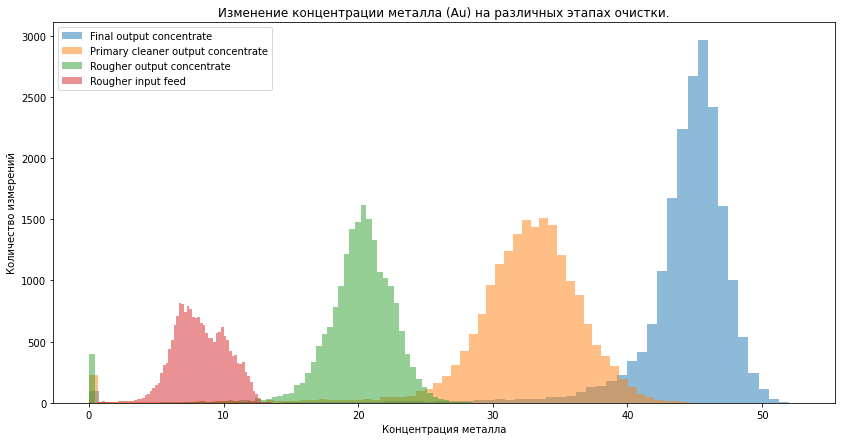

In [15]:
hist_metall(df_full['final_output_concentrate_au'], 
            df_full['primary_cleaner_output_concentrate_au'], 
            df_full['rougher_output_concentrate_au'], 
            df_full['rougher_input_feed_au'], 
            'Au')

### Смотрим динамику по серебру.

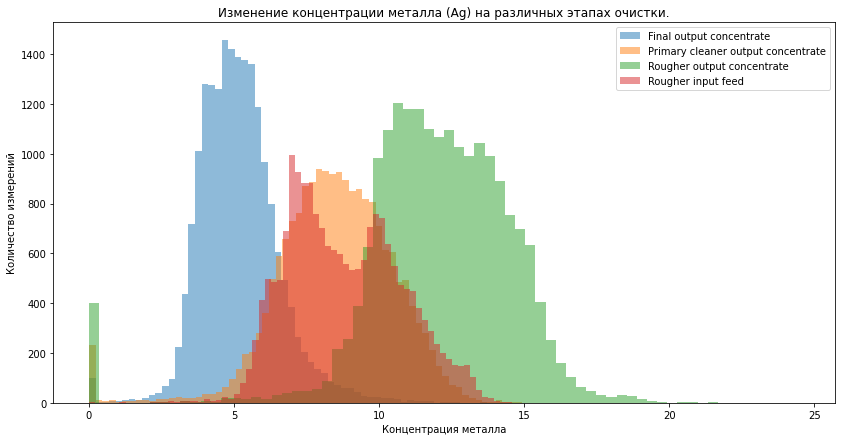

In [16]:
hist_metall(df_full['final_output_concentrate_ag'], 
            df_full['primary_cleaner_output_concentrate_ag'], 
            df_full['rougher_output_concentrate_ag'], 
            df_full['rougher_input_feed_ag'], 
            'Ag')

### Смотрим динамику по свинцу.

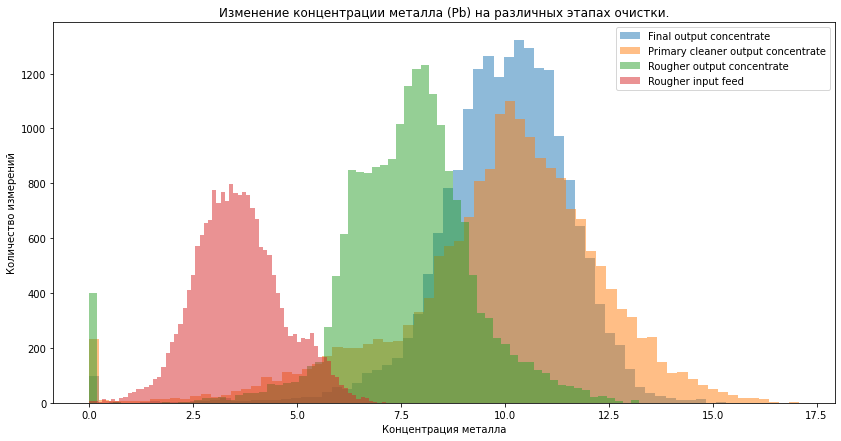

In [17]:
hist_metall(df_full['final_output_concentrate_pb'], 
            df_full['primary_cleaner_output_concentrate_pb'], 
            df_full['rougher_output_concentrate_pb'], 
            df_full['rougher_input_feed_pb'], 
            'Pb')

### Вывод.
Концентрация золота явно растет, концентрация остальных металлов имеет разнонаправленную динамику. Предполагаем, что обо связанно с особенностями технического процесса.


Также явно прослеживается небольшой пик на нулевых значениях. Логично предположить что это просто попадается пустая порода. Так как нам нужно обучать модель на настоящем сырье, а не пытаться оптимизировать процесс на пустой породе, смело отбрасываем эту часть данных в выборке.


### Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках.

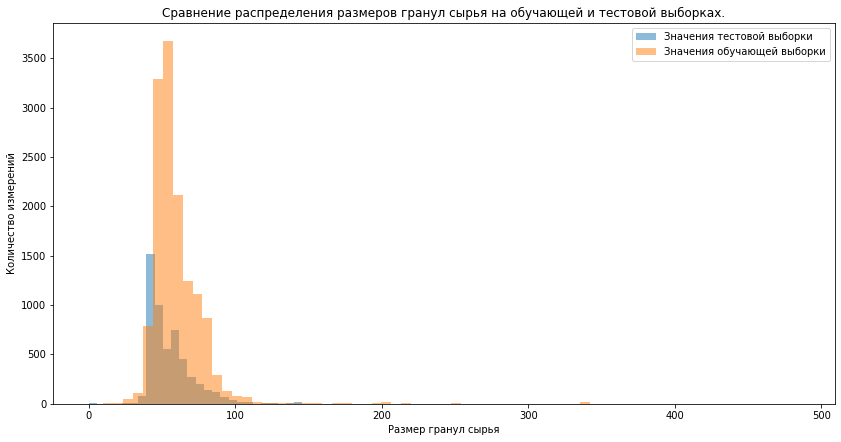

In [18]:
    plt.figure(figsize=(14,7))
    plt.hist(df_test['rougher_input_feed_size'], bins=70, alpha=0.5, label='Значения тестовой выборки')
    plt.hist(df_train['rougher_input_feed_size'], bins=70, alpha=0.5, label='Значения обучающей выборки')
    pl.xlabel("Размер гранул сырья")
    pl.ylabel("Количество измерений")
    plt.title('Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках.')
    plt.legend()
    plt.show()

### Вывод.
Размеры гранул сырья на обучающей и тестовой выборках сопоставимы. Распределения не сильно отличаются друг от друга, так что оценка модели будет корректной.


### Изменение суммарных концентраций веществ.

### Задаём функцию для графических построений.

In [19]:
def total_concentration (rougher_input, rougher_output, final_output):
    plt.figure(figsize=(14,7))
    plt.hist(rougher_input, bins=70, alpha=0.5, label='Rougher input')
    plt.hist(rougher_output, bins=70, alpha=0.5, label='Rougher output')
    plt.hist(final_output, bins=70, alpha=0.5, label='Final output')
    pl.xlabel("Концентрация веществ")
    pl.ylabel("Количество измерений")
    name = 'Изменение суммарных концентраций всех веществ на различных этапах очистки.'
    plt.title(name)
    plt.legend()
    plt.show()

### Анализируем изменение суммарных концентраций веществ.

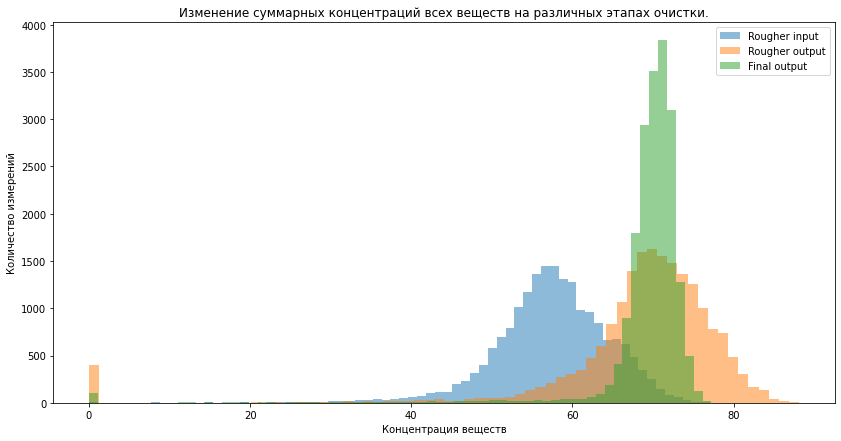

In [20]:
rougher_input = (df_full['rougher_input_feed_au'] 
             + df_full['rougher_input_feed_ag']
             + df_full['rougher_input_feed_pb']
             + df_full['rougher_input_feed_sol'])

rougher_output = (df_full['rougher_output_concentrate_au'] 
             + df_full['rougher_output_concentrate_ag']
             + df_full['rougher_output_concentrate_pb']
             + df_full['rougher_output_concentrate_sol'])

final_output = (df_full['final_output_concentrate_au'] 
             + df_full['final_output_concentrate_ag']
             + df_full['final_output_concentrate_pb']
             + df_full['final_output_concentrate_pb'])

total_concentration(rougher_input, rougher_output, final_output)

### Удаляем данные с нулевым суммарным количеством веществ.

In [21]:
temp = rougher_input*rougher_output*final_output
df_full['temp'] = temp

df_temp_3 = df_full.loc[df_test.index]
df_temp_3 = df_temp_3.drop((set(df_temp_3.columns) - set(df_test.columns)) - set(['temp']) , axis=1)
df_test = df_temp_3[df_temp_3['temp'] != 0]
df_test = df_test.drop('temp' , axis=1)

df_temp_4 = df_full.loc[df_train.index]
df_temp_4 = df_temp_4.drop((set(df_temp_4.columns) - set(df_train.columns)) - set(['temp']) , axis=1)
df_train = df_temp_4[df_temp_4['temp'] != 0]
df_train = df_train.drop('temp' , axis=1)

### Удаляем оставшиеся пропуски в данных

In [22]:
df_test = df_test.dropna() 
df_train = df_train.dropna() 

df_train = df_train.drop(['date'], axis=1)
df_test = df_test.drop(['date'], axis=1)

### Вывод.
В результате анализа данных были удалены данные характерные для пустой породы. 


## Модель

### Функция для вычисления sMAPE


In [23]:
def final_smape(y, y_hat):
    y_rougher = y.iloc[:, 0]
    y_hat_rougher = y_hat[:, 0]
 
    rougher_num = np.abs(y_rougher - y_hat_rougher)
    rougher_den = (np.abs(y_rougher) + np.abs(y_hat_rougher)) / 2
    smape_rougher = np.mean(rougher_num / rougher_den) * 100
 
    y_final = y.iloc[:, 1]
    y_hat_final = y_hat[:, 1]
 
    final_num = np.abs(y_final - y_hat_final)
    final_den = (np.abs(y_final) + np.abs(y_hat_final)) / 2
    smape_final = np.mean(final_num / final_den) * 100
 
    final_smape = smape_rougher * 0.25 + smape_final * 0.75
    return np.abs(final_smape)

### Готовим выборки

In [24]:
features_train = df_train.drop(['recovery_new', 'final_output_recovery'], axis=1)
target_train = df_train[['recovery_new', 'final_output_recovery']]

features_test = df_test.drop(['recovery_new', 'final_output_recovery'], axis=1)
target_test = df_test[['recovery_new', 'final_output_recovery']]

print ('features_train имеет размерность:', features_train.shape)
print ('target_train имеет размерность:', target_train.shape)

print ('features_test имеет размерность:', features_test.shape)
print ('target_test имеет размерность:', target_test.shape)

features_train имеет размерность: (13046, 52)
target_train имеет размерность: (13046, 2)
features_test имеет размерность: (4977, 52)
target_test имеет размерность: (4977, 2)


In [25]:
smape_score = make_scorer(final_smape, greater_is_better=False)

### Модель «Дерево решений»

In [26]:
model = DecisionTreeRegressor(random_state=1234)
parametrs = { 'max_depth': range (1,21, 5) }
grid = GridSearchCV(model, parametrs, cv=5, scoring=smape_score)
grid.fit(features_train,target_train)
grid.best_params_

{'max_depth': 1}

In [27]:
model = DecisionTreeRegressor(random_state=1234, 
                              max_depth=grid.best_params_['max_depth'])
model.fit(features_train, target_train)
predictions = model.predict(features_test)
final_smape(target_test, predictions)
print ('sMAPE =', final_smape(target_test, predictions))

df_smape = pd.DataFrame({'name': ['Модель «Дерево решений»'],
                         'sMAPE': [final_smape(target_test, predictions)]})

sMAPE = 8.25491322891372


### Модель «Случайный лес»

In [28]:
model = RandomForestRegressor(random_state=1234)
parametrs = { 'n_estimators': range (10, 31, 10), 'max_depth': range (1,5, 2) }
grid = GridSearchCV(model, parametrs, cv=5, scoring=smape_score)
grid.fit(features_train,target_train)
grid.best_params_

{'max_depth': 3, 'n_estimators': 10}

In [29]:
model = RandomForestRegressor(random_state=1234, 
                              max_depth=grid.best_params_['max_depth'], 
                              n_estimators=grid.best_params_['n_estimators'])
model.fit(features_train, target_train)
predictions = model.predict(features_test)
print ('sMAPE =', final_smape(target_test, predictions))

df_smape.loc[len(df_smape.index)] = ['Модель «Случайный лес»', 
                                     final_smape(target_test, predictions)]

sMAPE = 7.584903582766598


### Модель «Линейная регрессия»

In [30]:
model = LinearRegression()
parametrs = { }
grid = GridSearchCV(model, parametrs, cv=5, scoring=smape_score)
grid.fit(features_train,target_train)
grid.best_score_

-8.860418688612466

In [31]:
model = LinearRegression()
model.fit(features_train, target_train)
predictions = model.predict(features_test)
print ('sMAPE =', final_smape(target_test, predictions))

df_smape.loc[len(df_smape.index)] = ['Модель «Линейная регрессия»', 
                                     final_smape(target_test, predictions)]

sMAPE = 6.690154371687154


In [32]:
model = DummyRegressor(strategy='mean')
model.fit(features_train, target_train)
predictions = model.predict(features_test)
print ('sMAPE =', final_smape(target_test, predictions))

df_smape.loc[len(df_smape.index)] = ['Константная медианная модель', 
                                     final_smape(target_test, predictions)]

sMAPE = 9.116078363570995


In [33]:
df_smape

,name,sMAPE
0,Модель «Дерево решений»,8.254913
1,Модель «Случайный лес»,7.584904
2,Модель «Линейная регрессия»,6.690154
3,Константная медианная модель,9.116078


## Вывод:
Наилучший результат был достигнут моделью «Линейная регрессия» со значением sMAPE = 6.69